In [1]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

import product_sub.settings as stg

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline,  make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer

import numpy as np
import pandas as pd


RANDOM_STATE=42

### Create Dataset

In [2]:
sns.distplot(dataset_merged[dataset_merged[stg.COL_RAW_NB_DAY_LAST_CONTACT]>-1][stg.COL_RAW_NB_DAY_LAST_CONTACT])

NameError: name 'dataset_merged' is not defined

### Pipeline

In [3]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])
rf = RandomForestClassifier()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

        AGE  HAS_DEFAULT  BALANCE  HAS_HOUSING_LOAN  HAS_PERSO_LOAN  \
2053   45.0            0      101                 1             0.0   
29618  28.0            0     3026                 0             0.0   
31449  36.0            0     9324                 1             0.0   
20076  32.0            0      727                 0             0.0   
43441  33.0            0      658                 1             0.0   
...     ...          ...      ...               ...             ...   
11284  44.0            0     1059                 0             0.0   
44732  23.0            0      508                 0             0.0   
38158  34.0            0     1317                 1             0.0   
860    33.0            0      165                 0             0.0   
15795  38.0            0      -41                 1             0.0   

       DURATION_CONTACT  NB_CONTACT  NB_DAY_LAST_CONTACT  \
2053                  1           5                    0   
29618                 1    

In [4]:
X_test.shape

(9028, 32)

In [5]:
X_train.shape


(36108, 32)

In [6]:
rf = RandomForestClassifier()
grid_params_rf = [{
                'criterion': ['entropy'],
                'min_samples_leaf': [40, 80],
                'max_depth': [15,25, 27],
                'min_samples_split': [3, 5, 10],
                'n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=RANDOM_STATE)
search = GridSearchCV(rf, grid_params_rf, n_jobs=-1, refit=True)
search.fit(X_train, y_train)
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [8]:
search.best_params_

{'criterion': 'entropy',
 'max_depth': 27,
 'min_samples_leaf': 40,
 'min_samples_split': 10,
 'n_estimators': 60}

In [9]:
rf = RandomForestClassifier(criterion='entropy', max_depth=27, min_samples_leaf=40, min_samples_split=10, n_estimators=60)
rdf = rf.fit(X_train, y_train)

In [10]:
rdf.feature_importances_.shape

(32,)

In [11]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [12]:
FINAL_COLUMNS = [
    stg.COL_RAW_AGE,
    stg.COL_RAW_HAS_DEFAULT,
    stg.COL_RAW_BALANCE,
    stg.COL_RAW_HAS_HOUSING_LOAN,
    stg.COL_RAW_HAS_PERSO_LOAN,
    stg.COL_RAW_DURATION_CONTACT,
    stg.COL_RAW_NB_CONTACT,
    stg.COL_RAW_NB_DAY_LAST_CONTACT,
    stg.COL_RAW_NB_CONTACT_LAST_CAMPAIGN,
    stg.COL_RAW_EMPL_VAR_RATE,
    stg.COL_RAW_IDX_CSMR_PRICE,
    stg.COL_RAW_IDX_CSMR_CONFIDENCE,
    stg.COL_MONTH,
    stg.COL_WEEKDAY,
    "is_first_campaign",
    # "nb_contact_last_campaign_inf_4",
    # "nb_contact_last_campaign_inf_8",
    # "nb_contact_last_campaign_inf_12",
    # "nb_contact_last_campaign_sup_12",
    # "short_duration_contact",
    # "middle_duration_contact",
    # "long_duration_contact",
    # "so_long_contact",
    stg.COL_RAW_STATUS,
    stg.COL_RAW_EDUCATION,
    stg.COL_RAW_CONTACT,
    "is_last_campaign_success",
    "is_last_campaign_fail",
    "Admin",
    "Chomeur",
    "Col bleu",
    "Employe de menage",
    "Entrepreneur",
    "Etudiant",
    "Independant",
    "Manager",
    "Retraite",
    "Services",
    "Technicien",
    "Autre",
]

In [13]:
len(FINAL_COLUMNS)

32

In [14]:
rdf.feature_importances_.shape

(32,)

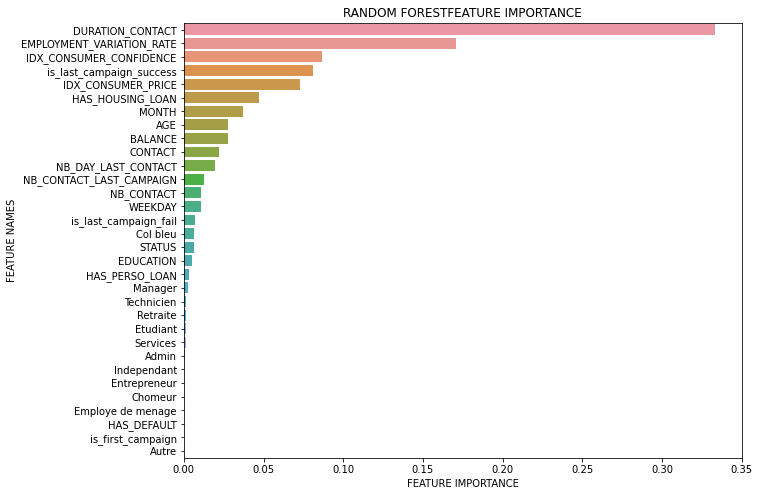

In [16]:
plot_feature_importance(rdf.feature_importances_,FINAL_COLUMNS,'RANDOM FOREST')